In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
import numpy as np

In [2]:
# CHANGE-COUNTER
counter = 'gs'
csv = 'data/' + counter + '.csv'
title = 'gs'
data = pd.read_csv(csv)
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
#data = data.iloc[::-1].reset_index(drop=True)

In [3]:
#training = data.iloc[:data.shape[0]-504]
#eval = data.iloc[data.shape[0]-504:]
training = pd.DataFrame(data)

## MA & EMA

In [4]:
# MA
training['MA-Close'] = data['Close'].rolling(10).mean()

In [5]:
x = training['Date']
y = training['Close']
y_ma = training['MA-Close']

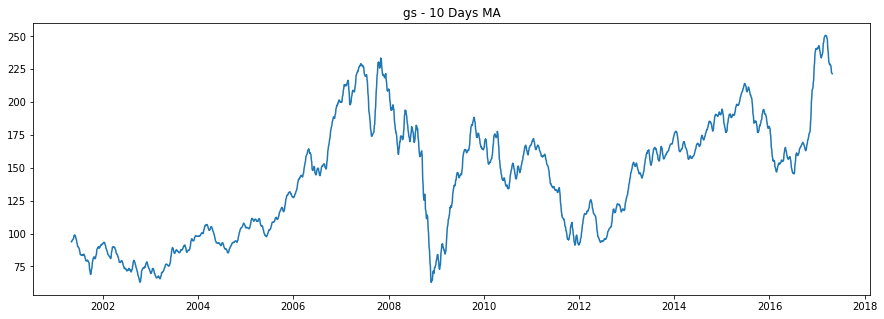

In [6]:
plt.plot(x,y_ma, figure=plt.figure(figsize=(15,5)))
plt.title(title + ' - 10 Days MA')
plt.show()

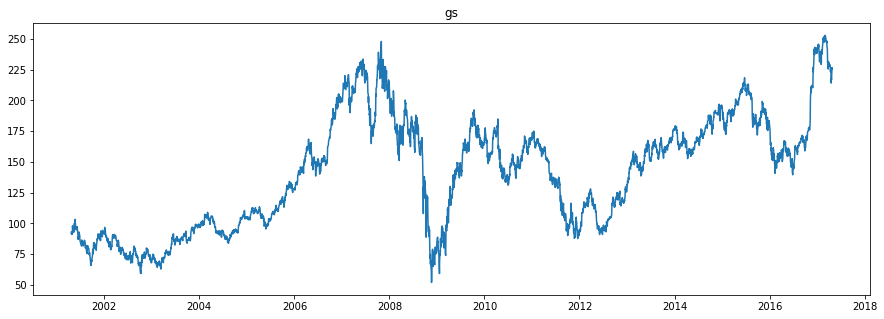

In [7]:
plt.plot(x,y, figure=plt.figure(figsize=(15,5)))
plt.title(title)
plt.show()

In [8]:
# 12 days Price EMA 
ema_span_1 = 12
sma = training["Close"].rolling(window=ema_span_1, min_periods=ema_span_1).mean()[:ema_span_1]
rest = training["Close"][ema_span_1:]
training["EMA-12-Close"] = pd.concat([sma, rest]).ewm(span=ema_span_1, adjust=False).mean()

In [9]:
# 12 days Volume EMA 
sma = training["Volume"].rolling(window=ema_span_1, min_periods=ema_span_1).mean()[:ema_span_1]
rest = training["Volume"][ema_span_1:]
training["EMA-12-Volume"] = pd.concat([sma, rest]).ewm(span=ema_span_1, adjust=False).mean()

In [10]:
# 26 days Price EMA
ema_span_2 = 26
sma = training["Close"].rolling(window=ema_span_2, min_periods=ema_span_2).mean()[:ema_span_2]
rest = training["Close"][ema_span_2:]
training["EMA-26-Close"] = pd.concat([sma, rest]).ewm(span=ema_span_2, adjust=False).mean()

In [11]:
# Graphing
y_ema_1 = training['EMA-12-Close']
y_ema_2 = training['EMA-26-Close']

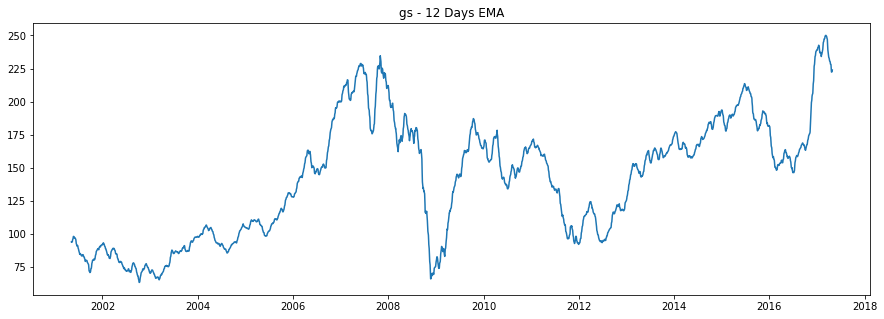

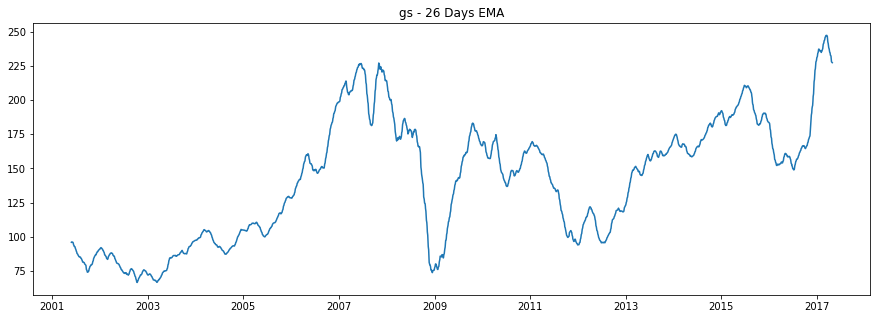

In [12]:
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_ema_1,figure=fig)
plt.title(title + ' - 12 Days EMA')
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_ema_2,figure=fig)
plt.title(title + ' - 26 Days EMA')
plt.show()

## Volatility

In [13]:
# Use all data to calculate volatility distribution
ema_span_1 = 12
sma = data["Close"].rolling(window=ema_span_1, min_periods=ema_span_1).mean()[:ema_span_1]
rest = data["Close"][ema_span_1:]
data["EMA-12-Close"] = pd.concat([sma, rest]).ewm(span=ema_span_1, adjust=False).mean()

daily_ema_returns = data['EMA-12-Close'].pct_change()

In [14]:
volatility = pd.DataFrame(data['Date'])
z_value = 1.65 #95% confidence, any z value that above this belongs to the rare 5%

In [15]:
volatility['volatility-ema-12'] = daily_ema_returns

In [16]:
mu = abs(data['EMA-12-Close'].pct_change()).mean()
sigma = abs(data['EMA-12-Close'].pct_change()).std()

In [17]:
z = (abs(daily_ema_returns)-mu)/sigma
volatility['z'] = z
volatility['above_threshold'] = volatility['z'] > z_value
volatility['negative'] = volatility['volatility-ema-12'] < 0
volatility['neg_and_above_threshold'] = (volatility['negative'] & volatility['above_threshold'])
#volatility.to_csv('volatility.csv', index=False)
training['neg_and_above_threshold'] = volatility['neg_and_above_threshold']

## PPO

In [18]:
training["PPO"] = ((training["EMA-12-Close"] - training["EMA-26-Close"])/training["EMA-26-Close"])*100

In [19]:
PPO_ema_span = 9
sma = training["PPO"].rolling(window=PPO_ema_span, min_periods=PPO_ema_span).mean()[ema_span_2-1:ema_span_2-1+PPO_ema_span]
rest = training["PPO"][ema_span_2-1+PPO_ema_span:]
training["PPO-EMA-Trigger"] = pd.concat([sma, rest]).ewm(span=PPO_ema_span, adjust=False).mean()

In [20]:
d = (training["PPO"] - training["PPO-EMA-Trigger"])


In [21]:
# Graphing
y_ppo = training['PPO']
y_ppo_trigger = training['PPO-EMA-Trigger']

ppo_above = pd.Series(np.nan, index=list(range(0,training.shape[0])))
ppo_below = pd.Series(np.nan, index=list(range(0,training.shape[0])))

d = (training["PPO"] - training["PPO-EMA-Trigger"])

for i in range(1, len(d)):
    if d[d.index[0]+i] * d[d.index[0]+i-1] < 0.:
        # crossover at i
        if(d[d.index[0]+i] > 0.):
            ppo_above[i] = training.loc[d.index[0]+i, "PPO-EMA-Trigger"]
        else:
            ppo_below[i] = training.loc[d.index[0]+i, "PPO-EMA-Trigger"]

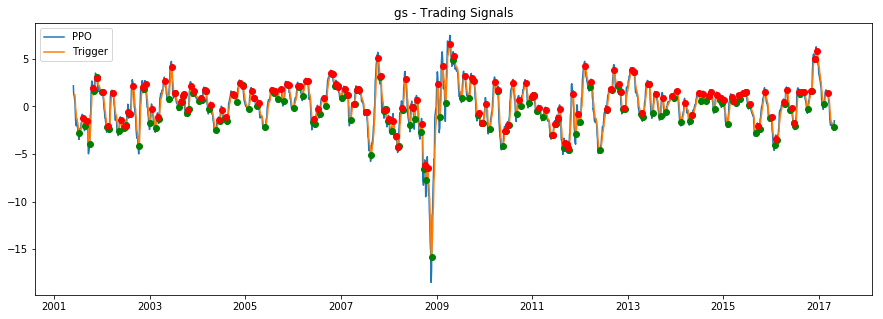

In [22]:
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_ppo,figure=fig, label="PPO")
plt.plot(x,y_ppo_trigger,figure=fig, label="Trigger")
plt.plot(x,ppo_above, 'go', figure=fig)
plt.plot(x,ppo_below, 'ro', figure=fig)
plt.title(title + ' - Trading Signals')
plt.legend()
plt.show()

In [23]:
# MACD do i have to?

## RSI

In [24]:
# http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:relative_strength_index_rsi

rsi_span = 14
differences = training["Close"].diff(1)
df = pd.DataFrame(differences)
merged = pd.concat([df[df>=0], df[df<0]], axis=1)
merged.columns = ['Gains','Losses']
#training= pd.merge(training, merged, left_index=True, right_index=True)

In [25]:
first_gains = merged["Gains"][1:].fillna(0).rolling(window=rsi_span, min_periods=rsi_span).mean()[merged.index[0] + rsi_span]
first_losses = merged["Losses"][1:].fillna(0).rolling(window=rsi_span, min_periods=rsi_span).mean()[merged.index[0] + rsi_span]
first_rs = first_gains/abs(first_losses)
#first_rsi = 100 - (100 / (1 + first_rs))
rs = pd.Series(np.nan, index=list(range(0,rsi_span)))
rs[rsi_span] = first_rs

In [26]:
training["Avg-Gain"] = merged["Gains"][1:].fillna(0).rolling(window=rsi_span, min_periods=rsi_span).mean()
training["Avg-Loss"] = merged["Losses"][1:].fillna(0).rolling(window=rsi_span, min_periods=rsi_span).mean()

In [27]:
rest = (((training["Avg-Gain"].shift()*(rsi_span-1) + training["Avg-Gain"])/rsi_span)/abs((training["Avg-Loss"].shift()*(rsi_span-1) + training["Avg-Loss"])/rsi_span))[rsi_span+1:]

In [28]:
training["RS"] = pd.concat((rs,rest), axis=0)
training["RSI"] = 100 - (100 / (1 + training["RS"]))

In [29]:
overbought = pd.Series(np.nan, index=list(range(0,training.shape[0])))
oversold = pd.Series(np.nan, index=list(range(0,training.shape[0])))

d_overbought = (70 - training["RSI"])
for i in range(1, len(d_overbought)):
    if d_overbought[d_overbought.index[0] + i] * d_overbought[d_overbought.index[0] + i - 1] < 0.:
            # crossover at i
            if d_overbought[d_overbought.index[0] + i] < 0.:
                overbought[i] = 70 #small_data.loc[i, "RSI"]
            
        
        
d_oversold = (30 - training["RSI"])
for i in range(1, len(d_oversold)):
    if d_oversold[d_oversold.index[0] + i] * d_oversold[d_oversold.index[0] + i - 1] < 0.:
            # crossover at i
            if d_oversold[d_oversold.index[0] + i] > 0.:
                oversold[i] = 30 #small_data.loc[i, "RSI"]

In [30]:
# Graphing
y_rsi = training['RSI']

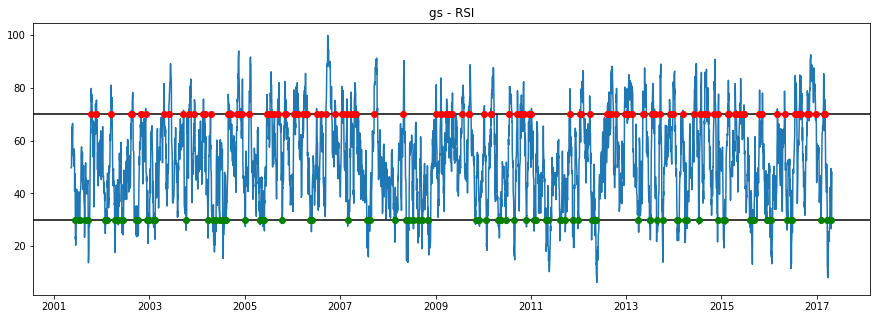

In [31]:
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_rsi,figure=fig, label="RSI")
plt.axhline(y=30, color='k', linestyle='-')
plt.axhline(y=70, color='k', linestyle='-')
plt.plot(x,oversold, 'go', figure=fig)
plt.plot(x,overbought, 'ro', figure=fig)
plt.title(title + ' - RSI')
plt.show()

### ADX & DMI (Strength & Direction)

In [32]:
#http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx

# DMI SPAN
dmi_span = 14

# Current High - Prior High
high_diff = training["High"] - training["High"].shift()
high_diff[high_diff<0] = 0

# Prior Low - Current Low
low_diff = training["Low"].shift() - training["Low"]
low_diff[low_diff<0] = 0

dmi = pd.concat([high_diff[high_diff>=low_diff], low_diff[low_diff>high_diff]], axis=1)
dmi.columns=["P_DI","N_DI"]
dmi.fillna(0, inplace=True)

training["P_DI"] = dmi["P_DI"].rolling(window=dmi_span, min_periods=dmi_span).mean()
training["N_DI"] = dmi["N_DI"].rolling(window=dmi_span, min_periods=dmi_span).mean()

In [33]:
# Calculate ATR
training["TR"] = training["High"] - training["Low"]
first_atr = training["TR"].rolling(window=dmi_span, min_periods=dmi_span).mean()[training.index[0] + dmi_span-1]
training["ATR"] = pd.Series(np.nan, index=list(range(0,training.shape[0])))
training["ATR"].loc[training.index[0] + dmi_span-1] = first_atr
for i in range(dmi_span, training.shape[0]):
    training.loc[training.index[0] + i, "ATR"] = (training.loc[training.index[0] + i-1, "ATR"] * (dmi_span -1) + training.loc[training.index[0] + i, "TR"])/dmi_span

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
# Calculate +DI14, -DI14 to be plotted with ADX
training["POS_DI14"] = (training["P_DI"] / training["ATR"]) * 100
training["NEG_DI14"] = (training["N_DI"] / training["ATR"]) * 100

In [35]:
# Calculate DX
training["DX"] = abs((training["POS_DI14"] - training["NEG_DI14"])/(training["POS_DI14"] + training["NEG_DI14"])) * 100

# Calculate ADX
first_adx = training["DX"].rolling(window=dmi_span, min_periods=dmi_span).mean()[training.index[0] + dmi_span*2-1]
training["ADX"] = pd.Series(np.nan, index=list(range(0,training.shape[0])))
training["ADX"].loc[training.index[0] + dmi_span*2-1] = first_adx
for i in range(dmi_span*2, training.shape[0]):
    training.loc[training.index[0] + i, "ADX"] = (training.loc[training.index[0] + i-1, "ADX"] * (dmi_span -1) + training.loc[training.index[0] + i, "DX"])/dmi_span

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


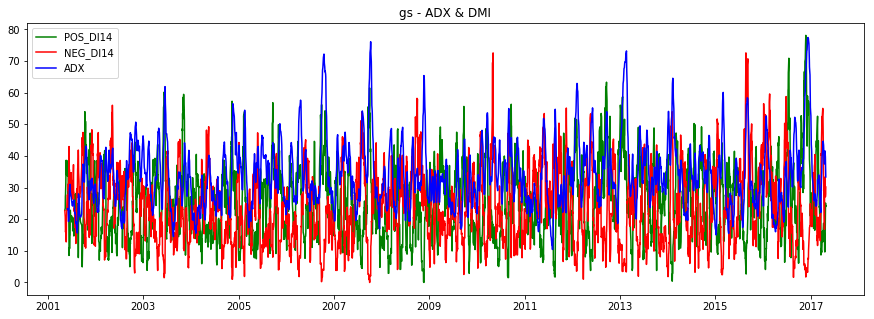

In [36]:
# Graphing
y_p_dmi = training['POS_DI14']
y_n_dmi = training['NEG_DI14']
y_adx = training["ADX"]
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_p_dmi,color='g',figure=fig, label="POS_DI14")
plt.plot(x,y_n_dmi,color='r',figure=fig, label="NEG_DI14")
plt.plot(x,y_adx, color='b', figure=fig, label="ADX")
plt.title(title + ' - ADX & DMI')
plt.legend()
plt.show()

### Everything

In [37]:
quarter = range(30, len(x), 80) # 80 data points = 4 months

In [38]:
training.loc[training['neg_and_above_threshold']].iterrows()

<generator object DataFrame.iterrows at 0x000001A9BF90D5C8>

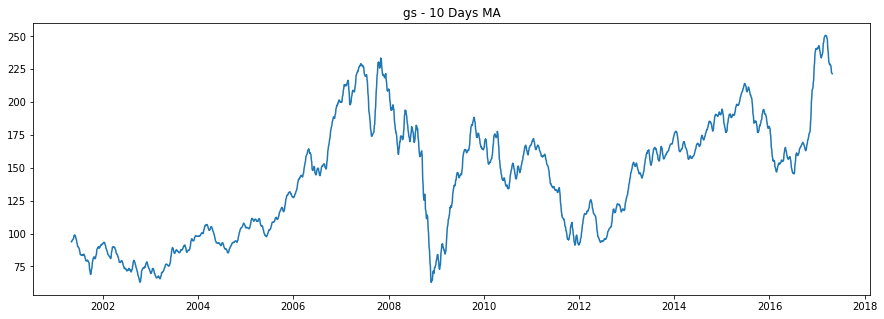

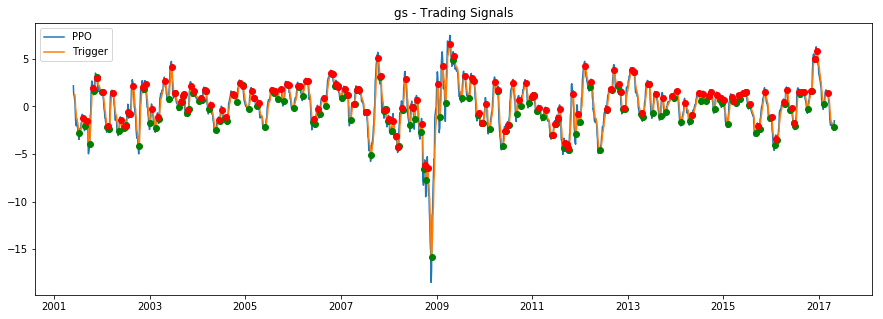

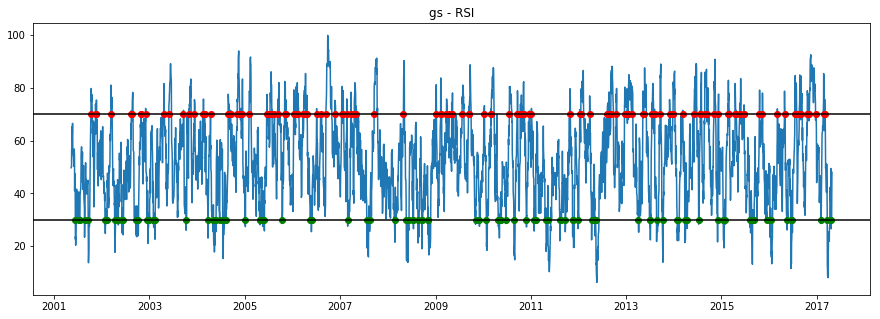

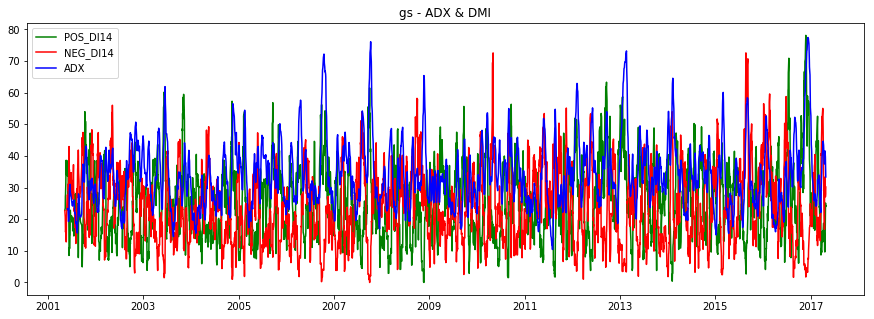

In [39]:
plt.plot(x,y_ma, figure=plt.figure(figsize=(15,5)))
#quarter = range(30, len(x), 80) # 80 data points = 4 months
#for i in quarter:
    #plt.axvline(x[i], color='k', linestyle='-')

#for index, row in training.loc[training['neg_and_above_threshold']].iterrows():
#    plt.axvline(row['Date'], color='k', linestyle='-')
    
    
plt.title(title + ' - 10 Days MA')


plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_ppo,figure=fig, label="PPO")
plt.plot(x,y_ppo_trigger,figure=fig, label="Trigger")
plt.plot(x,ppo_above, 'go', figure=fig)
plt.plot(x,ppo_below, 'ro', figure=fig)
plt.title(title + ' - Trading Signals')
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_rsi,figure=fig, label="RSI")
plt.plot(x,oversold, 'go', figure=fig)
plt.plot(x,overbought, 'ro', figure=fig)
plt.axhline(y=30, color='k', linestyle='-')
plt.axhline(y=70, color='k', linestyle='-')
plt.title(title + ' - RSI')
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(x,y_p_dmi,color='g',figure=fig, label="POS_DI14")
plt.plot(x,y_n_dmi,color='r',figure=fig, label="NEG_DI14")
plt.plot(x,y_adx, color='b', figure=fig, label="ADX")
plt.title(title + ' - ADX & DMI')
plt.legend()
plt.show()

In [40]:
training.to_csv("temp/"+ counter + "-technical-indicated.csv", index=False)

In [41]:
training

,Date,Open,High,Low,Close,Adj Close,Volume,MA-Close,EMA-12-Close,EMA-12-Volume,...,RS,RSI,P_DI,N_DI,TR,ATR,POS_DI14,NEG_DI14,DX,ADX
0,2001-04-23,94.000000,94.750000,92.500000,92.959999,77.151215,2063400,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.250000,NaN,NaN,NaN,NaN,NaN
1,2001-04-24,92.699997,93.739998,91.150002,91.400002,75.856506,2786500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.589996,NaN,NaN,NaN,NaN,NaN
2,2001-04-25,90.000000,93.300003,89.699997,92.820000,77.034981,3109700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.600006,NaN,NaN,NaN,NaN,NaN
3,2001-04-26,92.820000,96.099998,91.500000,92.489998,76.761124,4163200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.599998,NaN,NaN,NaN,NaN,NaN
4,2001-04-27,92.000000,94.690002,91.949997,92.940002,77.134644,4054700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.740005,NaN,NaN,NaN,NaN,NaN
5,2001-04-30,95.080002,95.080002,91.000000,91.099998,75.607491,2716800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.080002,NaN,NaN,NaN,NaN,NaN
6,2001-05-01,90.000000,93.099998,89.290001,92.650002,76.893944,3781600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.809997,NaN,NaN,NaN,NaN,NaN
7,2001-05-02,94.400002,98.500000,93.949997,98.000000,81.334091,4391200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.550003,NaN,NaN,NaN,NaN,NaN
8,2001-05-03,96.150002,96.750000,95.139999,96.000000,79.674225,3092900,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.610001,NaN,NaN,NaN,NaN,NaN
9,2001-05-04,94.000000,97.800003,93.800003,97.199997,80.670158,3000400,93.756000,NaN,NaN,...,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
